우선 모델의 학습을 재현하기 위해 random seed를 제어한다.

- `torch`
- `numpy`
- `random`
- `sklearn`에서는 random_state를 전달


In [78]:
import os
import pandas as pd
import numpy as np
import torch
import random

RAND_STATE = 9811

torch.manual_seed(RAND_STATE)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(RAND_STATE)
random.seed(RAND_STATE)


dataset을 train, validation, test으로 각각 6:2:2로 나눈다.  
이 때 `sklearn`의 `train_test_split`을 사용한다.  

In [79]:
from sklearn.model_selection import train_test_split

DATA_PATH = os.path.join(os.path.pardir, "dataset", "chap02", "car_evaluation.csv")


def get_data(data_path=DATA_PATH, test_size=0.2, val_size=0.2, random_state=RAND_STATE):
    if test_size + val_size >= 1.0:
        raise ValueError("sum of test_size and val_size must be less than 1.0")
    dataset = pd.read_csv(data_path)
    data = dataset.iloc[:, :-1]
    label = dataset.iloc[:, -1].to_frame()
    X_train, X_not_train, y_train, y_not_train = train_test_split(
        data, label, test_size=val_size + test_size, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_not_train,
        y_not_train,
        test_size=test_size / (test_size + val_size),
        random_state=random_state,
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


In [80]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data()
print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)
print("y_test.shape:", y_test.shape)


X_train.shape: (1036, 6)
X_val.shape: (346, 6)
X_test.shape: (346, 6)
y_train.shape: (1036, 1)
y_val.shape: (346, 1)
y_test.shape: (346, 1)


In [81]:
X_train


,price,maint,doors,persons,lug_capacity,safety
901,med,vhigh,3,4,small,med
997,med,high,2,more,big,med
1152,med,med,4,more,small,low
1665,low,low,3,more,small,low
1644,low,low,2,more,big,low
...,...,...,...,...,...,...
138,vhigh,high,3,2,med,low
1193,med,low,2,2,med,high
136,vhigh,high,3,2,small,med
441,high,vhigh,2,4,small,low


In [82]:
y_train


,output
901,unacc
997,acc
1152,unacc
1665,unacc
1644,unacc
...,...
138,unacc
1193,unacc
136,unacc
441,unacc


train set의 `output`을 그래프로 확인한다.  
`output`은 카테고리 데이터로, `unacc`, `acc`, `good`, `vgood` 중 한 가지 값으로 구성된다.  
다른 값에 비해 `good`와 `vgood`가 비중이 매우 적음을 알 수 있다.


<AxesSubplot:ylabel='None'>

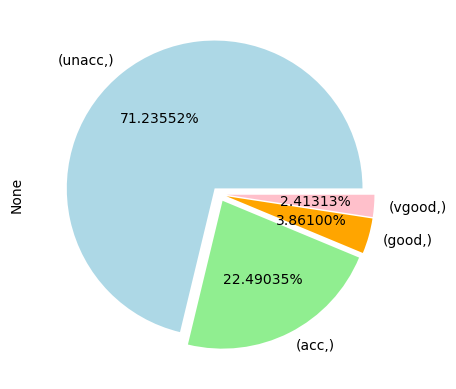

In [83]:
import matplotlib.pyplot as plt

y_train.value_counts().plot(
    kind="pie",
    autopct="%0.05f%%",
    colors=["lightblue", "lightgreen", "orange", "pink"],
    explode=(0.05, 0.05, 0.05, 0.05),
)


주어진 데이터는 모두 카테고리 데이터로 구성되어 있다.  
따라서 `sklearn`의 `OneHotEncoder`로 카테고리 데이터를 one-hot-encoded vector로 변환한다.  
데이터가 너무 가벼워서 gpu가 아닌 cpu 환경에서 학습하도록 한다.

In [84]:
from sklearn.preprocessing import OneHotEncoder

x_encoder = OneHotEncoder(sparse=False)

X_cat_train = x_encoder.fit_transform(X_train)
X_cat_train = torch.tensor(X_cat_train, dtype=torch.float)
print("X_columns:", x_encoder.get_feature_names_out())
print("X_cat_train.shape:",X_cat_train.shape)
X_cat_train[:5, :]


X_columns: ['price_high' 'price_low' 'price_med' 'price_vhigh' 'maint_high'
 'maint_low' 'maint_med' 'maint_vhigh' 'doors_2' 'doors_3' 'doors_4'
 'doors_5more' 'persons_2' 'persons_4' 'persons_more' 'lug_capacity_big'
 'lug_capacity_med' 'lug_capacity_small' 'safety_high' 'safety_low'
 'safety_med']
X_cat_train.shape: torch.Size([1036, 21])


tensor([[0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 1., 0.]])

In [85]:
y_encoder = OneHotEncoder(sparse=False)
y_cat_train = y_encoder.fit_transform(y_train)
y_cat_train = torch.tensor(y_cat_train, dtype=torch.float)
print("y_columns:", y_encoder.get_feature_names_out())
print("y_cat_train.shape:",y_cat_train.shape)
y_cat_train[:5]


y_columns: ['output_acc' 'output_good' 'output_unacc' 'output_vgood']
y_cat_train.shape: torch.Size([1036, 4])


tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

간단한 neural network 모델을 만든다.  
`Linear`, `ReLU`, `BatchNorm1d`, `Dropout`로 구성된 FC 레이어가 반복하는 구조이다.  
마지막에 `Linear`, `Softmax`로 `output`을 predict한다.  
이 레이어들을 `Sequential`로 묶어준다.

In [105]:
from torch import nn


class MyModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout=0.5) -> None:
        super().__init__()

        all_layers = []
        for hidden_size in hidden_layers:
            all_layers.append(nn.Linear(input_size, hidden_size))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(hidden_size))
            all_layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        all_layers.append(nn.Linear(hidden_layers[-1], output_size))
        all_layers.append(nn.Softmax(-1))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        return x


model = MyModel(X_cat_train.shape[1], y_cat_train.shape[1], [256, 128, 64])
model


MyModel(
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=4, bias=True)
    (13): Softmax(dim=-1)
  )
)

`output`의 클래스가 balance하지 않으므로 loss function에 가중치를 준다.
$$w_i=\frac {l(i)} {\sum_{k=1}^{n}{l(k)}}$$
이 때 $w$는 loss weight, $n$은 `output` 클래스의 개수이고, 함수 $l(i)$은 $i$번째 클래스의 데이터 개수이다.

loss function은 `CrossEntropyLoss`를, optimizer은 `Adam`을 사용한다.

In [106]:
def get_loss_weight():
    lens = torch.tensor(
        [y_cat_train[:, i].count_nonzero() for i in range(y_cat_train.shape[1])]
    )
    total = sum(lens)
    return total / lens


print("loss weight:", get_loss_weight())

loss_function = nn.CrossEntropyLoss(weight=get_loss_weight())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


loss weight: tensor([ 4.4464, 25.9000,  1.4038, 41.4400])


`epoch`를 1000으로 모델을 학습한다.

In [107]:
def train_model(
    model,
    train_data,
    train_output,
    val_data,
    val_output,
    optimizer,
    loss_function,
    epoch=1000,
):
    aggregated_train_losses = []
    aggregated_val_losses = []
    for i in range(1, epoch + 1):
        model.train()
        preds = model(train_data)
        loss = loss_function(preds, train_output)
        aggregated_train_losses.append(loss.item())
        if i % 100 == 0 or i == 1:
            print(f"epoch: {i:4} train loss: {loss.item():10.8f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            preds = model(val_data)
            loss = loss_function(preds, val_output)
            if i % 100 == 0 or i == 1:
                print(f"              val loss: {loss.item():10.8f}")
            aggregated_val_losses.append(loss.item())
    return aggregated_train_losses, aggregated_val_losses
    

X_cat_val = x_encoder.transform(X_val)
X_cat_val = torch.tensor(X_cat_val, dtype=torch.float)
y_cat_val = y_encoder.transform(y_val)
y_cat_val = torch.tensor(y_cat_val, dtype=torch.float)
train_losses, val_losses = train_model(model, X_cat_train, y_cat_train, X_cat_val, y_cat_val, optimizer, loss_function)

epoch:    1 train loss: 5.66163826
              val loss: 8.03125572
epoch:  100 train loss: 3.55128598
              val loss: 4.75989771
epoch:  200 train loss: 3.14490986
              val loss: 4.50574589
epoch:  300 train loss: 3.08001161
              val loss: 4.46144676
epoch:  400 train loss: 3.07377911
              val loss: 4.44411087
epoch:  500 train loss: 3.02204418
              val loss: 4.43415451
epoch:  600 train loss: 2.99573326
              val loss: 4.52239799
epoch:  700 train loss: 3.00142241
              val loss: 4.43792009
epoch:  800 train loss: 2.99316144
              val loss: 4.52464199
epoch:  900 train loss: 3.01439071
              val loss: 4.56864929
epoch: 1000 train loss: 2.98616767
              val loss: 4.55883837


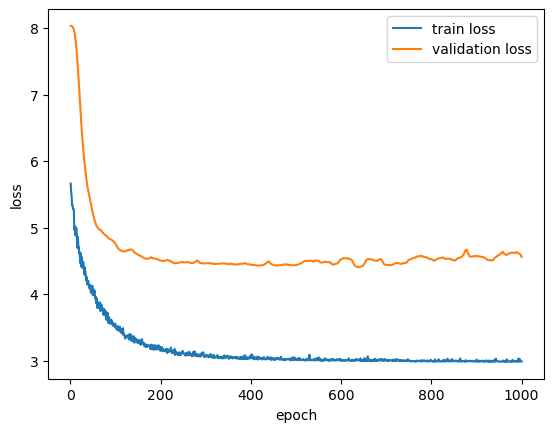

In [108]:
x_range = range(1, len(train_losses) + 1)
plt.plot(x_range, train_losses, label="train loss")
plt.plot(x_range, val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

모델 성능을 평가하기 위해 `sklearn`의 `classification_report`로 확인한 결과,  
각 클래스에 대한 f1-score가 모두 0.95 이상이다.

In [109]:
from sklearn.metrics import classification_report, accuracy_score


with torch.no_grad():
    model.eval()
    X_cat_val = x_encoder.transform(X_val)
    X_cat_val = torch.tensor(X_cat_val, dtype=torch.float)
    preds = model(X_cat_val)
    y_cat_val = y_encoder.transform(y_val)
    y_cat_val = torch.tensor(y_cat_val, dtype=torch.float)
    print(
        classification_report(
            y_cat_val.argmax(-1),
            preds.cpu().argmax(-1),
            target_names=y_encoder.get_feature_names_out(),
            digits=4,
        )
    )


              precision    recall  f1-score   support

  output_acc     0.9643    1.0000    0.9818        81
 output_good     0.9333    1.0000    0.9655        14
output_unacc     1.0000    0.9956    0.9978       228
output_vgood     1.0000    0.8696    0.9302        23

    accuracy                         0.9884       346
   macro avg     0.9744    0.9663    0.9688       346
weighted avg     0.9889    0.9884    0.9883       346



In [110]:
from sklearn.metrics import classification_report, accuracy_score


with torch.no_grad():
    model.eval()
    X_cat_val = x_encoder.transform(X_test)
    X_cat_val = torch.tensor(X_cat_val, dtype=torch.float)
    preds = model(X_cat_val)
    y_cat_val = y_encoder.transform(y_test)
    y_cat_val = torch.tensor(y_cat_val, dtype=torch.float)
    print(
        classification_report(
            y_cat_val.argmax(-1),
            preds.cpu().argmax(-1),
            target_names=y_encoder.get_feature_names_out(),
            digits=4,
        )
    )


              precision    recall  f1-score   support

  output_acc     0.9333    1.0000    0.9655        70
 output_good     1.0000    1.0000    1.0000        15
output_unacc     1.0000    0.9918    0.9959       244
output_vgood     1.0000    0.8235    0.9032        17

    accuracy                         0.9855       346
   macro avg     0.9833    0.9538    0.9662       346
weighted avg     0.9865    0.9855    0.9854       346

